# Data Exploration: Land surface temperature in Baltimore

In [1]:
%matplotlib inline
import os 
dir_primary = 'F:/UrbanDataProject/land_surface_temperature/code/analysis'
# os.chdir('/home/tml/research/land_surface_temperature/code/analysis')
os.chdir(dir_primary)
from analysis import *
code_dir = os.getcwd()
os.chdir('../..')

# import libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# regression libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
from sklearn.metrics import mean_squared_error, r2_score
# from xgboost import XGBRegressor

RANDOM_SEED = 3201

In [2]:
grid_size = 100
cities = ['bal', 'por', 'det', 'phx']
# import data
df = import_data(grid_size, selected_vars = False)
df_uns = pd.read_csv('data/data_regressions_{}_20190405_unnormalized.csv'.format(grid_size))

In [3]:
df_uns.lcov_11.value_counts().sum()
(1-184161/188274)*100

2.1845820453169296

# Describe

In [4]:
df.head()

,alb_max,alb_max_sl,alb_mean,alb_mean_sl,alb_min,alb_min_sl,alb_sd,alb_sd_sl,bldg,city,...,tree_max,tree_max_sl,tree_mean,tree_mean_sl,tree_min,tree_min_sl,tree_sd,tree_sd_sl,x,y
0,-0.510886,-0.527488,-0.482933,-0.744549,-0.423814,-0.741951,-0.354906,-0.201506,-1.040304,bal,...,-0.547521,-0.062028,-0.469860,-0.442970,-0.362027,-0.364994,-0.381825,0.079104,427296.178971,189412.211496
1,-0.527836,-0.455469,-0.505927,-0.724378,-0.403665,-0.723918,-0.475449,-0.088628,-1.040304,bal,...,-0.487274,-0.355959,-0.458366,-0.489353,-0.273438,-0.385839,-0.388483,-0.251075,427396.178971,189412.211496
2,-0.500503,-0.566046,-0.480185,-0.690498,-0.363103,-0.632684,-0.454122,-0.342036,-1.040304,bal,...,-0.547521,-0.607901,-0.463292,-0.512119,-0.273438,-0.344150,-0.431520,-0.582285,427496.178971,189412.211496
3,-0.482305,-0.653235,-0.538480,-0.649462,-0.562114,-0.494596,-0.185088,-0.580164,-1.040304,bal,...,-0.547521,-0.635894,-0.463292,-0.516136,-0.273438,-0.323305,-0.431520,-0.623577,427596.178971,189412.211496
4,-0.573154,-0.789062,-0.496423,-0.751910,-0.385327,-0.617439,-0.535160,-0.651370,-1.040304,bal,...,-0.547521,-0.635894,-0.463292,-0.542919,-0.273438,-0.364994,-0.431520,-0.578997,427696.178971,189412.211496


## Response

f:\urbandataproject\land_surface_temperature\venv\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


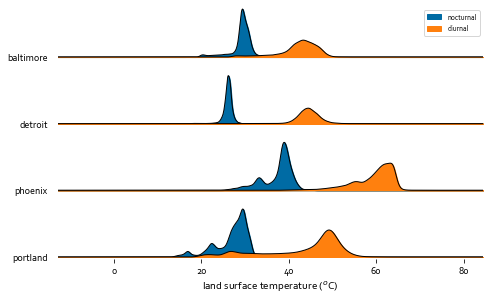

<Figure size 432x288 with 0 Axes>

In [5]:
joyplot_lst(df_uns, grid_size)

0.8832372624730305
0.8269152438600845
0.5103963815437131
0.8329128915370503


f:\urbandataproject\land_surface_temperature\venv\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


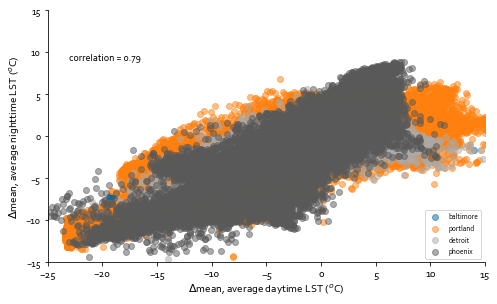

<Figure size 432x288 with 0 Axes>

In [6]:
# scatter and calculate the correlation between lst night and day
scatter_lst(df, cities, grid_size)

0.7794090058414178
0.7466608231982755
0.3820450103718121
0.820037274170816


f:\urbandataproject\land_surface_temperature\venv\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


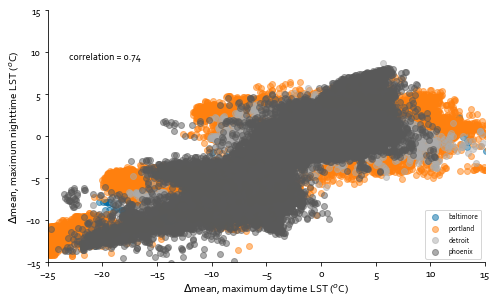

<Figure size 432x288 with 0 Axes>

In [7]:
scatter_maxlst(df, cities, grid_size)

# Independent variables

f:\urbandataproject\land_surface_temperature\venv\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


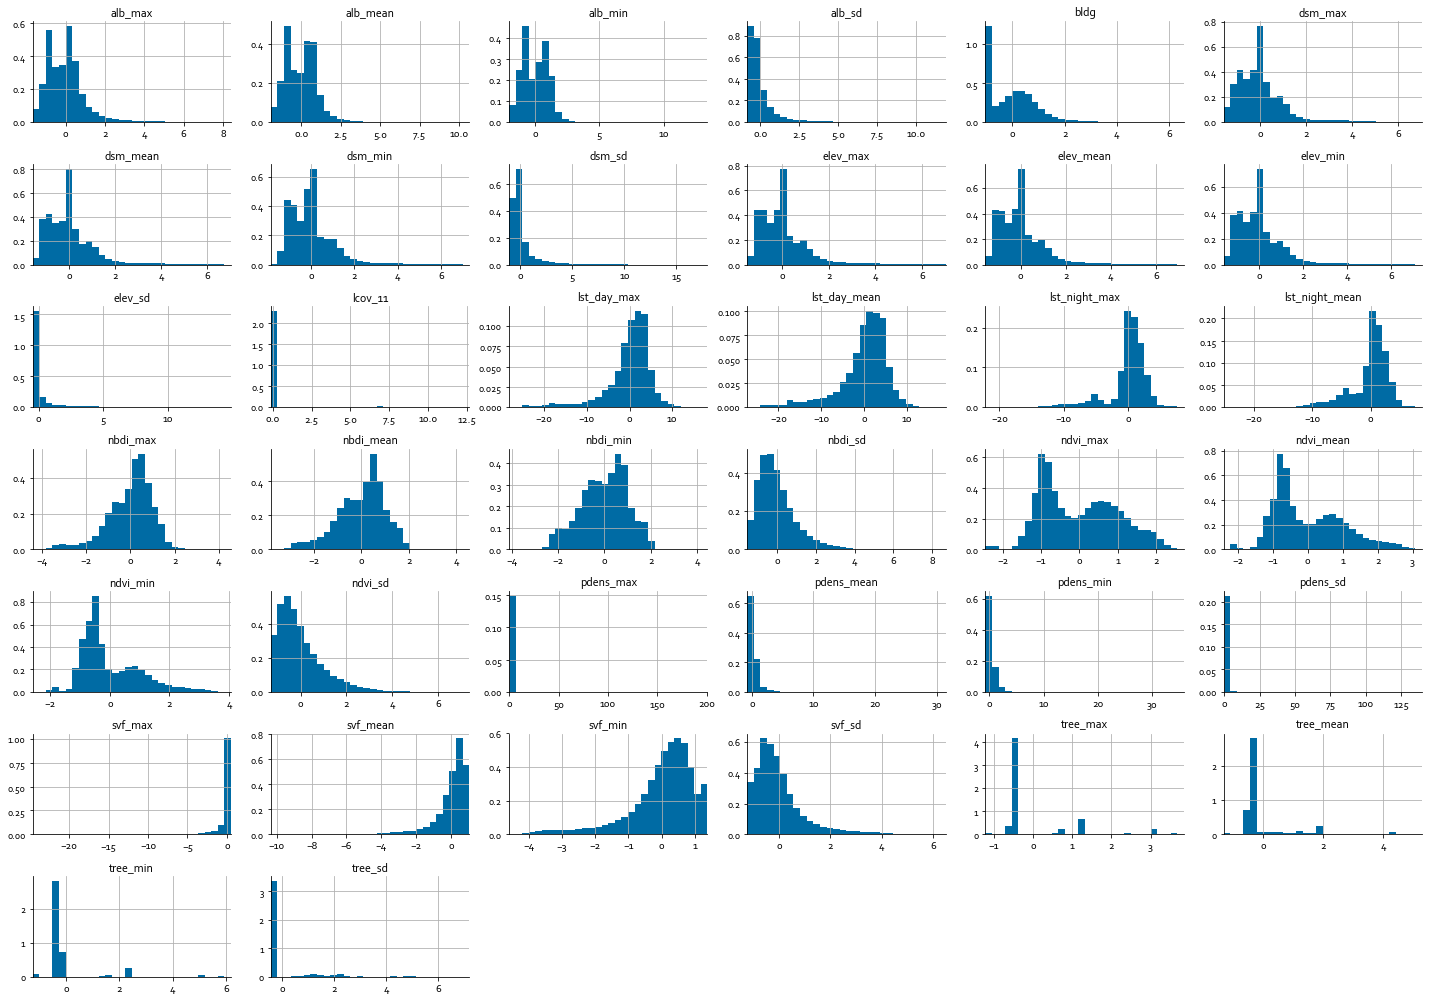

In [8]:
vars_plt = list(df.columns.values)
vars_plt = [x for x in vars_plt if x not in ['x','y','holdout']]
vars_plt = [x for x in vars_plt if 'sl' not in x]
df[vars_plt].hist(bins = 30, figsize=(20,14), density = True)
plt.show()

1.0
0.9999999999999999
1.0
0.9999999999999999


f:\urbandataproject\land_surface_temperature\venv\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


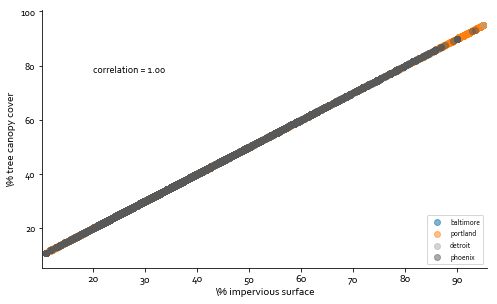

<Figure size 432x288 with 0 Axes>

In [9]:
# scatter impervious surface and tree canopy
scatter_tree_imp(df_uns, cities, grid_size)

## Drop variables based on collinearity

In [10]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Automatic approach

In [11]:
# # run a regression

# #gather features
# vars_reg = [x for x in df.columns.values if x not in ['x','y','holdout',"lst_day_mean", 'lst_night_mean']]

# # loop until features with a vif > 10 are removed
# vif_10 = True
# while vif_10:
#     features = "+".join(vars_reg)
#     # get y and X dataframes based on this regression:
#     y, X = dmatrices('lst_night_mean ~' + features, df, return_type='dataframe')
#     # For each X, calculate VIF and save in dataframe
#     vif = pd.DataFrame()
#     vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
#     vif["features"] = X.columns
#     # is there a variable with vif > 10
#     vif_10 = vif['VIF Factor'].max() > 5
#     # remove the variable with the highest vif, if the vif is greater than 10
#     if vif_10:
#         var_remove = vif.loc[vif['VIF Factor'].idxmax(),'features']
#         vars_reg.remove(var_remove)  
#         print(var_remove)

## Manual approach
If the VIF values are similar, then I'll won't drop the mean

In [12]:
# run a regression
####### this if for grid_size 500 *** it may be different for grid_size=100
if grid_size == 500:
    vars_remove = ['elev_mean_sl', 'elev_mean', 'elev_min_sl','dsm_mean_sl', 'elev_max_sl','elev_min','elev_max','dsm_min',
                  'nbdi_mean_sl','svf_sd_sl','alb_mean_sl','dsm_sd_sl','nbdi_min_sl','dsm_max_sl','dsm_max','ndvi_mean_sl',
                   'ndvi_max_sl', 'ndvi_max', 'nbdi_mean','elev_sd','dsm_min_sl','alb_max_sl','alb_min_sl','svf_sd','svf_mean_sl',
                  'tree_sd_sl','ndvi_sd_sl', 'alb_min','ndvi_min_sl','nbdi_min']
    vars_remove_5 = ['elev_sd_sl','svf_min_sl','tree_sd','tree_mean_sl','ndvi_min','svf_max_sl','nbdi_max_sl','nbdi_sd',
                     'ndvi_sd','alb_max','alb_sd','alb_sd_sl','nbdi_sd_sl', 'svf_min']
    vars_remove_more = ['pdens_min','pdens_max','pdens_sd','']
    # drop if correlation is greater than 0.8
    vars_remove_corr = ['lcov_11_sl','tree_max_sl','tree_min_sl']
else: 
    # grid size = 100
    vars_remove = ['elev_mean_sl','elev_max_sl','elev_min_sl','elev_max','elev_min','dsm_mean_sl','dsm_min_sl','dsm_min',
                  'ndvi_max_sl','nbdi_min_sl','nbdi_mean_sl','ndvi_min_sl','nbdi_max_sl','ndvi_mean_sl','dsm_max_sl','alb_max_sl',
                  'alb_min_sl','alb_mean_sl','elev_mean','dsm_max','ndvi_max','tree_max_sl','svf_sd_sl','nbdi_min','nbdi_max',
                  'nbdi_mean','alb_max','tree_mean_sl','alb_min','ndvi_min','alb_sd','tree_min_sl','svf_mean_sl','tree_max',
                   'pdens_sd_sl','svf_sd','pdens_mean_sl','pdens_max_sl','svf_min_sl','pdens_sd','elev_sd_sl','dsm_sd_sl',
                   'tree_min','svf_min']
    vars_remove_5 = ['dsm_sd','lcov_11_sl','ndvi_sd_sl']
    vars_remove_more = ['alb_sd_sl',]
    # drop if correlation is greater than 0.8
    vars_remove_corr = ['pdens_min','pdens_max','pdens_sd','pdens_min_sl','elev_sd','svf_max_sl','nbdi_sd']
#gather features
vars_reg = [x for x in df.columns.values if x not in ['x','y','holdout','city',"lst_day_mean", 'lst_night_mean',"lst_day_max", 'lst_night_max'] + vars_remove + vars_remove_5 + vars_remove_more+ vars_remove_corr]

# evalue the VIF and inspect by eye. add variable to remove to vars_remove
features = "+".join(vars_reg)
# get y and X dataframes based on this regression:
y, X = dmatrices('lst_night_mean ~' + features, df, return_type='dataframe')
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
# sort
vif = vif.sort_values(by='VIF Factor', ascending=False)
print(len(vif))
vif


14


,VIF Factor,features
1,2.695966,alb_mean
6,2.592747,ndvi_mean
10,2.334446,svf_mean
13,2.290031,tree_sd_sl
12,1.983626,tree_sd
5,1.861462,nbdi_sd_sl
2,1.830031,bldg
9,1.782541,svf_max
11,1.667924,tree_mean
7,1.636345,ndvi_sd


In [13]:
# update df
variables = ['x','y','holdout','city',"lst_day_mean", 'lst_night_mean',"lst_day_max", 'lst_night_max'] + list(vif.features)
variables.remove('Intercept')
df = df[variables]

In [14]:
# save data
df.to_csv('data/data_vif_{}.csv'.format(grid_size))

# Explore correlations

In [15]:
corr_matrix = df.corr()
corr_matrix

,x,y,holdout,lst_day_mean,lst_night_mean,lst_day_max,lst_night_max,alb_mean,ndvi_mean,svf_mean,tree_sd_sl,tree_sd,nbdi_sd_sl,bldg,svf_max,tree_mean,ndvi_sd,lcov_11,dsm_mean,pdens_mean
x,1.000000,-0.892453,-0.120875,0.000661,0.000535,0.000574,0.000388,-0.597580,0.389594,-0.236339,-0.192623,-0.134154,0.319973,-0.051270,-0.054358,-0.204269,0.245159,0.056641,0.000892,0.036420
y,-0.892453,1.000000,0.515270,0.012891,0.004642,0.010603,0.000580,0.563676,-0.454229,0.195868,0.209067,0.146164,-0.388026,0.044985,0.008538,0.220281,-0.285569,-0.003393,0.023767,-0.113372
holdout,-0.120875,0.515270,1.000000,0.039723,0.019557,0.033262,0.008326,-0.040833,-0.137338,-0.195202,0.098667,0.069084,-0.142273,0.010889,-0.167742,0.055299,-0.072687,0.155153,0.063835,-0.134384
lst_day_mean,0.000661,0.012891,0.039723,1.000000,0.790362,0.952287,0.666574,0.259095,-0.329033,0.201519,-0.351629,-0.275158,0.082350,0.457870,0.260196,-0.530043,0.021906,-0.424156,-0.310193,0.299515
lst_night_mean,0.000535,0.004642,0.019557,0.790362,1.000000,0.728345,0.890962,0.158269,-0.204512,-0.024905,-0.374066,-0.299643,0.099108,0.378085,0.113333,-0.667804,0.054913,-0.371163,-0.196587,0.282843
lst_day_max,0.000574,0.010603,0.033262,0.952287,0.728345,1.000000,0.739124,0.253997,-0.322005,0.195328,-0.213097,-0.072195,0.128061,0.411943,0.256157,-0.478307,0.084080,-0.401482,-0.330533,0.250288
lst_night_max,0.000388,0.000580,0.008326,0.666574,0.890962,0.739124,1.000000,0.143329,-0.171545,-0.059737,-0.157555,0.016840,0.142011,0.295986,0.091778,-0.580684,0.109922,-0.324458,-0.199739,0.203459
alb_mean,-0.597580,0.563676,-0.040833,0.259095,0.158269,0.253997,0.143329,1.000000,-0.640894,0.441566,0.033353,0.009914,-0.279624,0.356045,0.255759,0.062784,-0.293562,-0.195074,-0.136954,-0.048317
ndvi_mean,0.389594,-0.454229,-0.137338,-0.329033,-0.204512,-0.322005,-0.171545,-0.640894,1.000000,-0.467503,0.074089,0.070654,0.407228,-0.243331,-0.193083,0.078593,0.344201,-0.216046,0.210761,0.034252
svf_mean,-0.236339,0.195868,-0.195202,0.201519,-0.024905,0.195328,-0.059737,0.441566,-0.467503,1.000000,-0.001026,-0.010011,-0.177847,-0.063750,0.582185,0.010519,-0.138659,0.084405,-0.316913,-0.121636


f:\urbandataproject\land_surface_temperature\venv\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


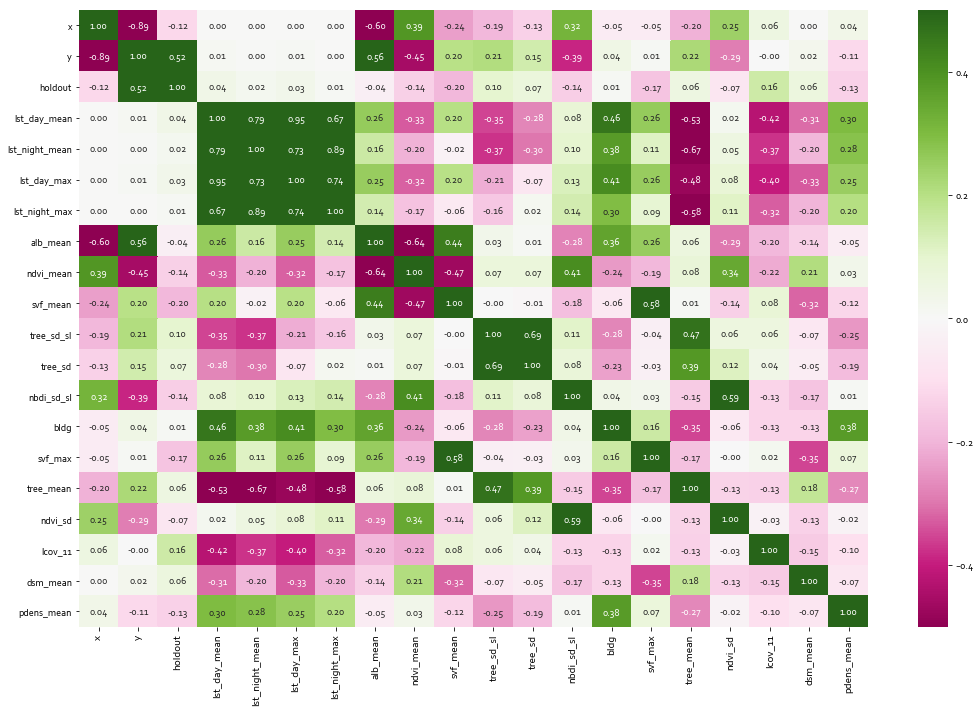

In [16]:
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, 
            cmap='PiYG',
            xticklabels=corr_matrix.columns,
            yticklabels=corr_matrix.columns,
            vmin=-0.5,vmax=0.5,center=0, 
            annot = True, fmt='.2f')